In [1]:
# Weights in Frozen Layers don't change

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224, 224)
classifier = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape = IMAGE_SHAPE+(3,))
])

In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

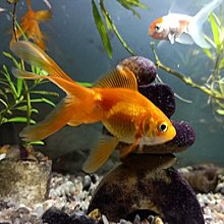

In [5]:
gold_fish = Image.open('goldfish2.jpg').resize(IMAGE_SHAPE)
gold_fish

In [6]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [7]:
gold_fish[0]

array([[0.21960784, 0.32156863, 0.30980392],
       [0.23529412, 0.33333333, 0.32156863],
       [0.24705882, 0.32156863, 0.3372549 ],
       [0.25882353, 0.31764706, 0.3372549 ],
       [0.28627451, 0.31372549, 0.34509804],
       [0.2745098 , 0.29019608, 0.30980392],
       [0.27843137, 0.2745098 , 0.25882353],
       [0.29803922, 0.28235294, 0.24313725],
       [0.49019608, 0.46666667, 0.37254902],
       [0.54901961, 0.5254902 , 0.38823529],
       [0.51372549, 0.48235294, 0.31764706],
       [0.50196078, 0.47058824, 0.29019608],
       [0.49411765, 0.4627451 , 0.27843137],
       [0.44313725, 0.41176471, 0.22745098],
       [0.30196078, 0.2627451 , 0.09019608],
       [0.25098039, 0.20784314, 0.05098039],
       [0.33333333, 0.2627451 , 0.13333333],
       [0.30196078, 0.23137255, 0.13333333],
       [0.23137255, 0.21960784, 0.15686275],
       [0.23921569, 0.27058824, 0.24313725],
       [0.29019608, 0.32941176, 0.34901961],
       [0.28627451, 0.32156863, 0.37254902],
       [0.

In [8]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [9]:
result = classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 1s 1s/step


In [10]:
result.shape

(1, 1001)

In [11]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [12]:
image_labels=[]
with open("ImageNetLabels.txt", "r") as f :
    image_labels=f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [13]:
image_labels[predicted_label_index]

'goldfish'

In [14]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)

In [15]:
data_dir

'.\\datasets\\flower_photos'

In [16]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [17]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [18]:
roses = list(data_dir.glob('roses/*'))

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [20]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [21]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [22]:
img.shape

(240, 179, 3)

In [23]:
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [24]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images :
        img=cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [25]:
X=np.array(X)
y=np.array(y)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [28]:
predicted = classifier.predict(np.array([X[0], X[1], X[2]]))

1/1 [==============================] - 1s 1s/step


In [29]:
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 880, 795], dtype=int64)

In [30]:
image_labels[795]

'shower curtain'

In [31]:
image_labels[880]

'umbrella'

In [32]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_last_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [33]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_last_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=1)

76/86 [=========================>....] - ETA: 8s - loss: 0.8227 - accuracy: 0.6924

In [ ]:
model.evaluate(X_test_scaled, y_test)